<a href="https://colab.research.google.com/github/srdg/bangla-dl/blob/master/PyTorch_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Acquisition
Download the [CMATERdb](https://www.dropbox.com/s/55bhfr3ycvsewsi/CMATERdb%203.1.2.rar) pattern recognition database and clean up `/content` directory.

In [1]:
!wget --quiet -O database.rar https://www.dropbox.com/s/55bhfr3ycvsewsi/CMATERdb%203.1.2.rar
!unrar x database.rar > /dev/null
!rm -rf database.rar sample_data
!mv BasicFinalDatabase/ data/

# Library imports
Import necessary libaries.  
We use `os` for listing files, `albumentations`, `numpy` and `PIL` for image processing, and `matplotlib` to display a subset of the images.

In [15]:
import os

import cv2 as cv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

from PIL import Image
import albumentations as A

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchsummary import summary

# Exploratory Data Analysis
Let us see how many distinct classes we have. From the data it is already ascertained that we are working with `.bmp` images, which are bitmap images. Let us see how the images are defined in the dataset.

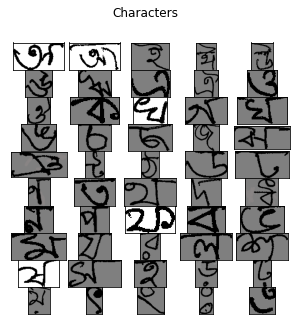

In [3]:
imgs = []
for folder in sorted(os.listdir('data/Train')):
  imgs.append('data/Train/'+folder+'/bcc000000.bmp')

%matplotlib inline
fig = plt.figure(figsize=(5,5))
fig.suptitle('Characters')
for idx in range(50):
    image = Image.open(imgs[idx])
    image = np.array(image)
    # image = np.array(image)[...,0] # comment prev. line and uncomment this to view a single layer
    plt.subplot(10,5,idx+1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(image, vmin=0, vmax=255)
    # plt.imshow(image, cmap='gray') # comment prev. line and uncomment this to view a single layer
    plt.subplots_adjust(hspace=0, wspace=0)
    
plt.show()

## Checking image-specific details
Looks like all images do not have the same dimensions. Let us see how many of them are unique and see a sample dimension.

In [4]:
img_dims, files = [], []
for folder in sorted(os.listdir('data/Train')):
  tmp = ['data/Train/'+folder+'/'+i for i in sorted(os.listdir('data/Train/'+folder))]
  for i in tmp:
    files.append(i)
img_dims = [np.array(Image.open(i)).shape for i in files]
print("Among", len(img_dims), "images, there are", len(set(img_dims)), "unique dimensions.")
print("Sample dimension:", img_dims[0])

Among 12000 images, there are 4879 unique dimensions.
Sample dimension: (53, 98, 3)


### How does the image look in each layer?
It is a bitmap image with 3 layers. Let us look at each layer in a sample image individually and plot them to see if we can identify any discernible changes.

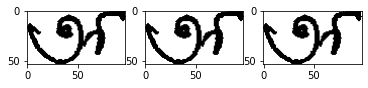

In [5]:
f=files[0]
a=np.array(Image.open(f))
for i in range(a.shape[-1]):
  plt.subplot(1,3,i+1)
  plt.imshow(a[...,i], cmap='gray') # cmap has to be mentioned else plt will map with 'viridis' cmap

Interestingly, we see that there is no change in the image in each layer, it is simply stacked up! Maybe we can use a single layer to train a network in this case.

# Defining our labels
Define our labels in Unicode (UTF-8). We associate each directory with a class.

In [46]:
labels = {
    172:"\u0985",
    173:"\u0986",
    174:"\u0987",
    175:"\u0988",
    176:"\u0989",
    177:"\u098a",
    178:"\u098b",
    179:"\u098f",
    180:"\u0990",
    181:"\u0993",
    182:"\u0994",
    183:"\u0995",
    184:"\u0996",
    185:"\u0997",
    186:"\u0998",
    187:"\u0999",
    188:"\u099a",
    189:"\u099b",
    190:"\u099c",
    191:"\u099d",
    192:"\u099e",
    193:"\u099f",
    194:"\u09a0",
    195:"\u09a1",
    196:"\u09a2",
    197:"\u09a3",
    198:"\u09a4",
    199:"\u09a5",
    200:"\u09a6",
    201:"\u09a7",
    202:"\u09a8",
    203:"\u09aa",
    204:"\u09ab",
    205:"\u09ac",
    206:"\u09ad",
    207:"\u09ae",
    208:"\u09af",
    209:"\u09b0",
    210:"\u09b2",
    211:"\u09b6",
    212:"\u09b7",
    213:"\u09b8",
    214:"\u09b9",
    215:"\u09dc",
    216:"\u09dd",
    217:"\u09df",
    218:"\u09ce",
    219:"\u0982",
    220:"\u0983",
    221:"\u0981",
    }
print("Classes to train:", end=" ")
for i in list(labels.keys()):
  print(labels[i], end=" ")
print()
print("Number of distinct classes:", len(list(labels.keys())))

Classes to train: অ আ ই ঈ উ ঊ ঋ এ ঐ ও ঔ ক খ গ ঘ ঙ চ ছ জ ঝ ঞ ট ঠ ড ঢ ণ ত থ দ ধ ন প ফ ব ভ ম য র ল শ ষ স হ ড় ঢ় য় ৎ ং ঃ ঁ 
Number of distinct classes: 50


# Preparing file lists
We define the list of files to be used for training and testing.

In [7]:
train_files, test_files = [], []

for mode in ['Train', 'Test']:
  for folder in sorted(os.listdir('data/'+mode)):
    tmp = ['data/'+mode+'/'+folder+'/'+i for i in sorted(os.listdir('data/'+mode+'/'+folder))]
    for i in tmp:
      if 'Train' in mode:
        train_files.append(i)
      else:
        test_files.append(i)

In [43]:
class CharacterDataSet(Dataset):

  def __init__(self, files, transform=None):
    self.files = files
    self.transform = transform

  def __len__(self):
    return len(self.files)

  def __getitem__(self, idx):
    image = Image.open(files[idx])
    label = int(files[idx].split('/')[2]) # data/Train/172/bcc000000.bmp --> class 172
    image = np.array(image)[...,0]
    if self.transform:
      image = self.transform(image=image)["image"]
      # manual transform (binary thresholding) since library does not support this
      # see section "Checking threshold for binarizing images"
      image = cv.threshold(image, 126, 255, cv.THRESH_BINARY)[1] # uncomment to apply 
    image = image[..., np.newaxis]
    image = image /255.0
    sample = (image, label-172)
    return sample

In [44]:
transforms = A.Compose([A.Resize(32,32)])
training_data = CharacterDataSet(train_files, transform=transforms)
testing_data = CharacterDataSet(test_files, transform=transforms)

In [45]:
batch_size = 32
# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(testing_data, batch_size=batch_size, shuffle=True)

# Visualizing batches
Let us try to see a sample training batch and a sample testing batch. We will also use our pre-defined `labels` dictionary to identify the labels, and use a custom `Kalpurush` font to print the UTF-8 character labels on a `matplotlib` figure.

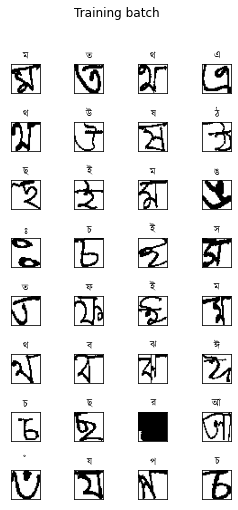

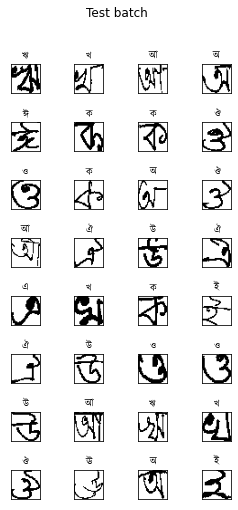

In [48]:
!wget --quiet -O kalpurush.ttf https://www.omicronlab.com/download/fonts/kalpurush.ttf
%matplotlib inline
prop = fm.FontProperties(fname='kalpurush.ttf')
fig_idx=1
for loader in [train_dataloader, test_dataloader]:
  fig = plt.figure(fig_idx, figsize=(4,8))
  fig.suptitle('Training batch' if fig_idx is 1 else 'Test batch')
  fig_idx+=1
  x,y=None,None
  for X, Y in loader:
    x=X
    y=Y
    break
  for i in range(32):
    plt.subplot(8,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.subplots_adjust(hspace=1, wspace=1)
    # print(labels[y[i].numpy().tolist()], end=" ")
    plt.title(labels[y[i].numpy().tolist()+172], fontproperties=prop)
    plt.imshow(x[i].squeeze(), cmap='gray')
  plt.show()

In [ ]:
# Refer https://stackoverflow.com/questions/65719005/

In [49]:
class Network(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 64, kernel_size=32, stride=1, padding=1)
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
    self.fc1 = nn.Linear(64, 64)
    self.fc2 = nn.Linear(64,50)

  def forward(self, x):
    # x = x.to(dtype=torch.uint8)
    x = self.conv1(x)
    x = F.relu(x)
    # print(x.shape)
    x = self.pool1(x)
    # print(x.shape)
    x = x.view(-1,64)
    # print(x.shape)
    x = self.fc1(x)
    # print(x.shape)
    x = F.relu(x)
    # print(x.shape)
    x = self.fc2(x)
    # print(x.shape)
    return x

In [50]:
net = Network()
# print(net)
summary(net, (1,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 64, 3, 3]          65,600
         MaxPool2d-2             [-1, 64, 1, 1]               0
            Linear-3                   [-1, 64]           4,160
            Linear-4                   [-1, 50]           3,250
Total params: 73,010
Trainable params: 73,010
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.28
Estimated Total Size (MB): 0.29
----------------------------------------------------------------


In [54]:
net = Network()
net = net.double()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adagrad(net.parameters())

size = len(train_dataloader)

num_epochs = 10
for epoch in range(num_epochs):
  for batch, data in enumerate(train_dataloader, 0):

    inputs, labels = data

    inputs = np.transpose(x, (0,3,1,2))

    optimizer.zero_grad()

    outputs = net(inputs.double())
    # print(outputs.shape, labels.shape)
    loss = criterion(outputs, labels)

    loss.backward()

    optimizer.step()

    if batch%100==0:
        loss, current = loss.item(), batch*len(X)
        print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")


loss: 3.908184 [    0/  375]
loss: 3.915676 [ 3200/  375]
loss: 3.917495 [ 6400/  375]
loss: 3.934653 [ 9600/  375]
loss: 3.918608 [    0/  375]
loss: 3.919751 [ 3200/  375]
loss: 3.907104 [ 6400/  375]
loss: 3.909229 [ 9600/  375]
loss: 3.899938 [    0/  375]
loss: 3.911545 [ 3200/  375]
loss: 3.907915 [ 6400/  375]
loss: 3.904642 [ 9600/  375]
loss: 3.919273 [    0/  375]
loss: 3.913443 [ 3200/  375]
loss: 3.913812 [ 6400/  375]
loss: 3.917517 [ 9600/  375]
loss: 3.914120 [    0/  375]
loss: 3.908098 [ 3200/  375]
loss: 3.910179 [ 6400/  375]
loss: 3.908894 [ 9600/  375]
loss: 3.909486 [    0/  375]
loss: 3.912607 [ 3200/  375]
loss: 3.912113 [ 6400/  375]
loss: 3.913920 [ 9600/  375]
loss: 3.907386 [    0/  375]
loss: 3.911102 [ 3200/  375]
loss: 3.916972 [ 6400/  375]
loss: 3.911095 [ 9600/  375]
loss: 3.915163 [    0/  375]
loss: 3.911893 [ 3200/  375]
loss: 3.912969 [ 6400/  375]
loss: 3.910767 [ 9600/  375]
loss: 3.911576 [    0/  375]
loss: 3.914332 [ 3200/  375]
loss: 3.913579

# Checking threshold for binarizing images
There are instances when the images contain the values `[0,127,255]` instead of `[0,255]` only. In such cases, we determine the thresholding value as 126 for the tests to be successful. Comment out the manual thresholding line in the CharacterDataset class if this transform is not to be applied.

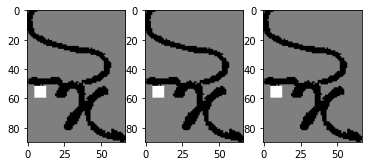

The original image has unique values as [0, 127, 255]


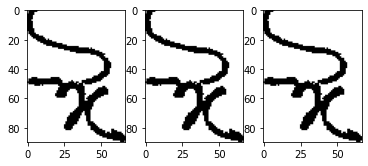

In [55]:
root = 'data/Test/175/bcc000001.bmp'
img = np.array(Image.open(root))
fig = plt.figure(1)
for i in range(img.shape[-1]):
  plt.subplot(1,3,i+1)
  plt.imshow(img[...,i], cmap='gray')
plt.show()
print("The original image has unique values as",np.unique(img[...,0]).tolist())
img = cv.threshold(img, 126, 255, cv.THRESH_BINARY)[1]
fig = plt.figure(2)
for i in range(img.shape[-1]):
  plt.subplot(1,3,i+1)
  plt.imshow(img[...,i], cmap='gray')
plt.show()